In [1]:
from collections import defaultdict
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns
import tqdm

import article

#### helper functions

#### munge data

Load source data, generate figure

In [2]:
PROJ_ROOT = pyprojroot.here()
RESULTS_ROOT = PROJ_ROOT / 'results'
FIGS_ROOT  = PROJ_ROOT / 'doc' / 'figures' / 'Supplementaries'

In [3]:
THIS_FIG_ROOT = fname = FIGS_ROOT / 'suppfig_filter_expts'
THIS_FIG_ROOT.mkdir(exist_ok=True)

In [4]:
# column name is "cleanup" but in the paper we use the term "post-processing"
# to avoid confusion with where we refer to "clean ups" of other models (e.g. SVM)
CLEANUPS = (
    'none',
    'min_segment_dur_majority_vote'
)

# so we'll add a column 'post-processing' that maps cleanups --> with/without post-process
POST_PROCESS_MAP = {
    'none': 'without',
    'min_segment_dur_majority_vote': 'with',
}

In [5]:
hyperparams_expt_df = pd.read_csv(PROJ_ROOT / 'doc' / 'figures' / 'mainfig_postprocess_error_rates' / 'fig5-data2.csv')

#### plot figure

In [6]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

In [7]:
PALETTE = sns.color_palette('colorblind')  # note: defaults to 10 colors

SPECIES_PALETTE = {
    'Bengalese Finches': PALETTE[4],
    'Canaries': PALETTE[7],
}

#### specify training set duration to use
to plot box plots; this duration is also indicated with arrows in the learning curve in the first column

In [8]:
TRAIN_SET_DUR_TO_USE = {
    'Bengalese Finch': 600,
}

We tested three different methods of post-processing; but to make the figure readable we just want to compare no post-processing with the method that performed best

In [9]:
CLEANUP = 'min_segment_dur_majority_vote'  # the one we show

In [10]:
CLEANUP_DASHES = {
    'none': 'dashed',
    'min_segment_dur_majority_vote': 'solid',
}

#### helper functions for plots
we define these here so that data we use is already loaded + munged

In [11]:
# so we'll add a column 'post-processing' that maps cleanups --> with/without post-process
POST_PROCESS_PALETTE = {
    'without': PALETTE[8],
    'with': PALETTE[9],
}

def plot_hyperparam(
    hyperparam_to_plot,
    fig=None,
    ax_arr=None,
    big_ax=None,
    legend=False,
    dpi=300,
    figsize=(3, 5.5),  # ~2/3 x 1/2 of (8.5 x 11). Padding added for legend
):
    """plot 2x2 grid of boxplots 
    representing results from a hyperparameter experiment,
    where rows are metrics and columns are species, 
    and box hue indicates with or without post-processing
    """
    if fig is None and ax_arr is None:
        fig, ax_arr = plt.subplots(2, 1, dpi=dpi, figsize=figsize)

    for ax_ in ax_arr.flatten():
        # too lazy to write out rc config
        ax_.tick_params(pad=0.1)
    
    if big_ax is None:
        big_ax = fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        big_ax.grid(False)
    SPECIES = (
        'Bengalese Finch',
    )

    HYPERPARAM_EXPTS = {
        'filter_num': 'No. of filters',
        'filter_size': 'Filter size',
    }

    # used to make these values bold in legend
    HYERPARAM_FOR_FINAL_RESULTS = {
        'Bengalese Finch': {
            'filter_num': 32,
            'filter_size': 5,
        },
    }

    METRICS = {
        'avg_error': 'Frame\nerror (%)',
        'avg_segment_error_rate': 'Syllable\nerror rate (%)'
    }

    YLIMS = {
        'Bengalese Finch': {
            'avg_error': (0., 7.),
            'avg_segment_error_rate': (0., 32.),
        },
    }

    for hyperparam_num, (hyperparam_expt, hyperparam_label) in enumerate(
        HYPERPARAM_EXPTS.items()
    ):
        if hyperparam_expt != hyperparam_to_plot:  # only plot hyperparam name that was passed un
            continue

        for col, species in enumerate(SPECIES):
            # use `metric_num` to compute row, `column_name` to get data from DataFrame, `label` as human-readable name for axes
            for metric_num, (metric_column_name, metric_label) in enumerate(METRICS.items()):
                data = hyperparams_expt_df[
                    (hyperparams_expt_df.species == species) &
                    (hyperparams_expt_df.hyperparam_expt == hyperparam_expt) & 
                    (hyperparams_expt_df.train_set_dur == TRAIN_SET_DUR_TO_USE[species])
                ]

                row = metric_num

                ax = ax_arr[row]

                if row == 0:
                    ax.set_title(species)

                # make it so we only generate one legend
                if row == 1 and col == 0:
                    plot_legend = True
                else:
                    plot_legend = False
                    
                g = sns.boxplot(
                    data=data,
                    x='hyperparam_val',
                    y=metric_column_name,
                    showfliers=False,
                    hue='Post-processing',
                    palette=POST_PROCESS_PALETTE,
                    ax=ax,
                )
                if plot_legend:
                    # let seaborn generate, then pop-off and re-use below
                    handles, labels = ax.get_legend_handles_labels()
                g.legend_.remove()  # always have to remove, no 'legend' argument for `sns.boxplot`

                ax.set_ylim(YLIMS[species][metric_column_name])

                ax.set_xlabel('')
                if row == 1 or row == 3:
                    new_xticklabels = []
                    for xticklabel in ax.get_xticklabels():
                        if int(xticklabel.get_text()) == HYERPARAM_FOR_FINAL_RESULTS[species][hyperparam_expt]:
                            # make bold using latex
                            new_xticklabels.append(
                                fr'$\bf{{{xticklabel.get_text()}}}$'
                            )
                        else:
                            new_xticklabels.append(xticklabel.get_text())
                    ax.set_xticklabels(new_xticklabels, rotation=45)                          
                else:
                    ax.set_xticklabels([])
            
                if col == 0:
                    ax.set_ylabel(f'{metric_label}\n@ max. train dur.')
                else:
                    ax.set_ylabel('')

        big_ax.set_xlabel(
            hyperparam_label, 
            fontweight='bold',
            labelpad=15,
        )

    sns.despine(fig)

    if legend:  # if boolean flag passed in was True, not `plot_legend` from loop above
        big_ax.legend(
            title='Post-processing',
            handles=handles,
            labels=['With', 'Without'],
            loc='lower right',
            bbox_to_anchor=(-0.4, -0.05)
        )
    
    return fig, ax_arr

In [12]:
sns.set_context("paper", font_scale=1.5)

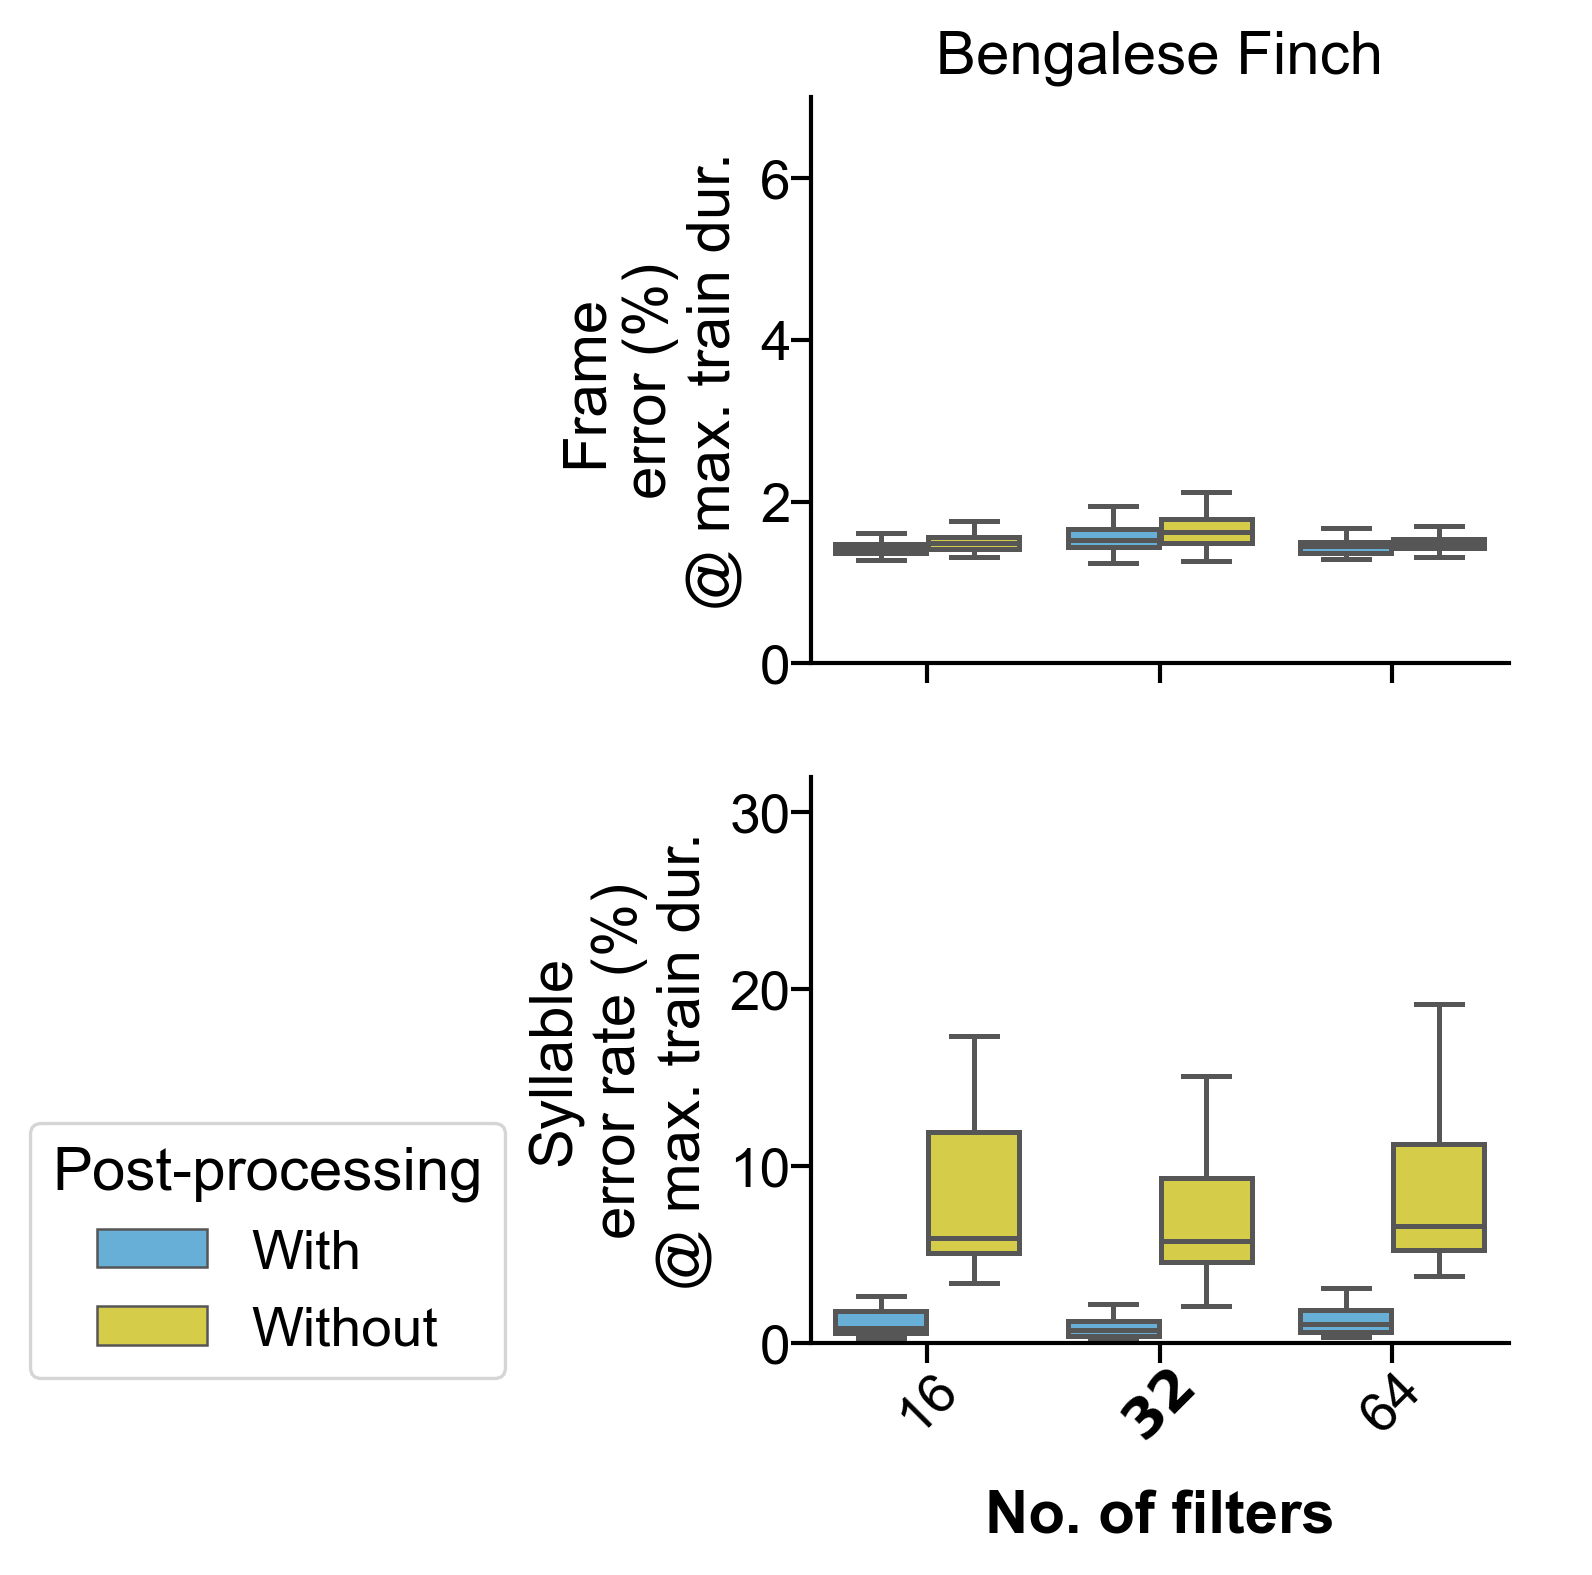

In [13]:
fig, _ = plot_hyperparam(
    hyperparam_to_plot='filter_num',
    legend=True  # hack, we will delete the legend from the SVM
)

for ext in ('svg', 'png'):
    fig.savefig(
        THIS_FIG_ROOT / f'filter-num-experiment-boxplots.{ext}',
        bbox_inches='tight',
    )

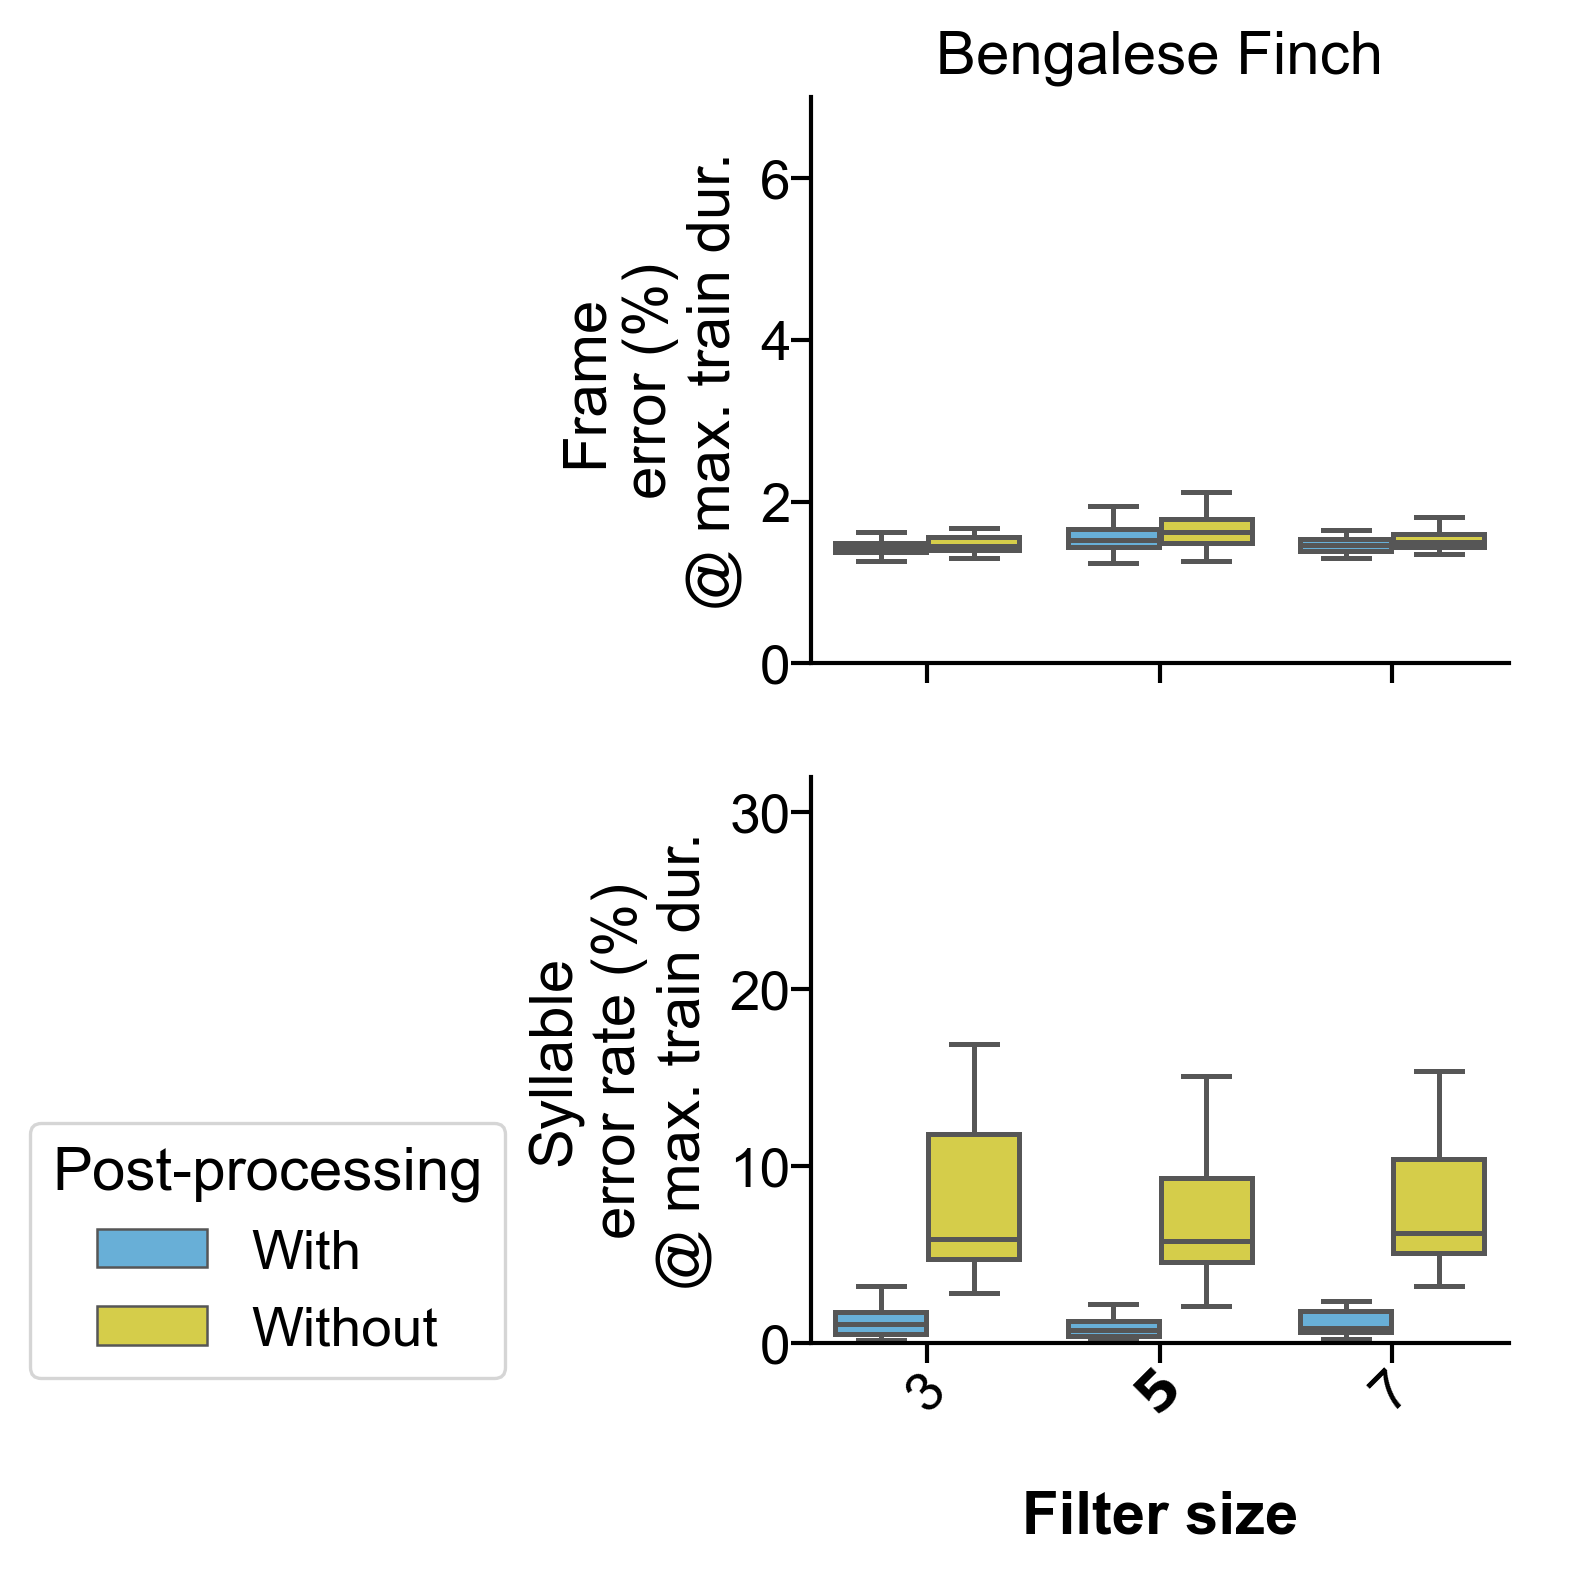

In [14]:
fig, _ = plot_hyperparam(
    hyperparam_to_plot='filter_size',
    legend=True,
)

for ext in ('svg', 'png'):
    fig.savefig(
        THIS_FIG_ROOT / f'filter-size-experiment-boxplots.{ext}',
        bbox_inches='tight',
    )